In [1]:
import numpy as np
from scipy.special import binom
from functools import cache
from itertools import product

# def combinations(a, b):
#     for i in range(len(a)):
#         for j in range(i, len(b)):
#             yield a[i], b[j]

def multinom(params):
    if len(params) == 1:
        return 1
    return binom(sum(params), params[-1]) * multinom(params[:-1])
    
def _partitions(n):
    if n == 0:
        yield []
        return
    for p in partitions(n-1):
        yield [1] + p
        if p and (len(p) < 2 or p[1] > p[0]):
            yield [p[0] + 1] + p[1:]

@cache
def partitions(n, size=None):
    if size is None:
        return tuple(_partitions(n))
    return tuple(p for p in _partitions(n) if len(p) == size)

# @cache
# def partitions(n):
#     return [p for p in _partitions(n) if len(p) == l]

def multinom(counts):
    if len(counts) == 1:
        return 1
    return binom(sum(counts), counts[-1]) * multinom(counts[:-1])

# def ton_counts(p, n):
#     return np.array([p.count(i) for i in range(0, n)])

def coalescent_reward_matrix(n):
    rewards = np.zeros((n, n))
    for p in partitions(n):
        # counts = ton_counts(p, n)
        counts = np.array([p.count(i) for i in range(0, n)])
        rewards[len(p)-1, :] += counts * multinom(counts)
    rewards = np.delete(rewards, 0, axis=0)
    rewards = np.delete(rewards, 0, axis=1)
    scale = np.array(range(2, n+1)) / rewards.sum(axis=1)
    rewards = rewards * scale[:, None]
    rewards = np.flip(rewards, axis=0)
    #reward_matrix = rewards.T
    reward_matrix = np.c_[  np.zeros(n-1), rewards.T, np.zeros(n-1) ]
    return reward_matrix

coalescent_reward_matrix(4)

array([[0.        , 4.        , 2.        , 0.66666667, 0.        ],
       [0.        , 0.        , 1.        , 0.66666667, 0.        ],
       [0.        , 0.        , 0.        , 0.66666667, 0.        ]])

In [128]:
def coalescent_state_reward(n, l):
    rewards = np.zeros(n+1)
    for p in partitions(n, size=l):
        # counts = ton_counts(p, n)
        counts = np.array([p.count(i) for i in range(0, n+1)])
        rewards = rewards + counts * multinom(counts)
    rewards = np.delete(rewards, 0, axis=0)
    if rewards.sum(): # so we can also call it with zero l
        scale = l / rewards.sum()
        rewards = rewards * scale
    return rewards[:-1] # the last one is for 1 lineage remaining, which is only relevant for ARGs

coalescent_state_reward(4, 3)

array([2., 1., 0.])

In [77]:
n = 4
lineage_counts = range(2,n+1)
rewards = np.c_[ [coalescent_state_reward(n, x) for x in lineage_counts] ]
rewards = np.flip(rewards, axis=0).T
rewards = np.c_[  np.zeros(n-1), rewards, np.zeros(n-1) ]
rewards

array([[0.        , 4.        , 2.        , 0.66666667, 0.        ],
       [0.        , 0.        , 1.        , 0.66666667, 0.        ],
       [0.        , 0.        , 0.        , 0.66666667, 0.        ]])

In [173]:

def ton_counts(p, n):
    return np.array([p.count(i) for i in range(0, n)])

def arg_state_reward(n, locus1, locus2, linked):

    l1, l2 = locus1 - linked, locus2 - linked

    def coal_rewards(l):
        r = np.zeros(n+1)
        for p in partitions(n, size=l):
            counts = np.array([p.count(i) for i in range(0, n+1)])
            r = r + counts * multinom(counts)
        scale = l / r.sum()
        r = r * scale            
        return r

    rewards = np.zeros((n+1, n+1))

    part = partitions(n, size=linked)
    for l1_p, l2_p in product(part, part):
        for a, b in product(l1_p, l2_p):
            rewards[a, b] += multinom(ton_counts(l1_p, n)) + multinom(ton_counts(l2_p, n)) 
    if rewards.sum():
        scale = linked / rewards.sum() 
        rewards *= scale

    if locus1 + locus2 == 0:
        return rewards
    if l1:
        rewards[0, :] = coal_rewards(l1)
    if l2:
        rewards[:, 0] = coal_rewards(l2)

    
    return rewards  

n, l1, l2, linked = 4, 3, 3, 3
rewards = arg_state_reward(n, l1, l2, linked)
rewards 

array([[0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 1.33333333, 0.66666667, 0.        , 0.        ],
       [0.        , 0.66666667, 0.33333333, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ]])

In [166]:
%%time
n = 10
mat_list = []
for locus1 in range(1, n+1):
    for locus2 in range(1, n+1):
        for linked in range(0, min(locus1, locus2)+1):
            mat_list.append(arg_state_reward(n, locus1, locus2, linked))

rewards = np.stack(mat_list)
print(rewards.shape, rewards.size)
rewards[:, 1, 1]

(485, 11, 11) 58685
CPU times: user 6.06 s, sys: 16.7 ms, total: 6.08 s
Wall time: 6.15 s


array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.02222222,
        0.        ,  0.        ,  0.02222222,  0.        ,  0.        ,
        0.02222222,  0.        ,  0.        ,  0.02222222,  0.        ,
        0.        ,  0.02222222,  0.        ,  0.        ,  0.02222222,
        0.        ,  0.        ,  0.02222222,  0.        ,  0.        ,
        0.02222222,  0.        ,  0.        ,  0.02222222,  0.        ,
        0.        ,  0.        ,  0.        ,  0.02222222,  0.        ,
        0.        ,  0.02222222,  0.13888889,  0.        ,  0.        ,
        0.02222222,  0.13888889,  0.        ,  0.        ,  0.02222222,
        0.13888889,  0.        ,  0.        ,  0.02222222,  0.13

----

In [ ]:

def ton_counts(p, n):
    return np.array([p.count(i) for i in range(0, n)])

def arg_state_reward(n, locus1, locus2, linked):
    assert locus1 + locus2

    rewards = np.zeros((n+1, n+1))
    
    l1, l2 = locus1 - linked, locus2 - linked

    # the l1 have no descendants at locus2 so they fill the top row

    # the l2 have no descendants at locus1 so they fill the left col

    # the linked have a number 1-n of descendants at each locus
    l1_part, l2_part = partitions(n, size=l1), partitions(n, size=l2)
    print(l1_part, l2_part)
    for l1_p, l2_p in product(l1_part, l2_part):
        for a, b in product(l1_p, l2_p):
            rewards[a, b] += multinom(ton_counts(l1_p, n)) + multinom(ton_counts(l2_p, n)) 

#    rewards = rewards / (l1 + l2)


    scale = np.arange(n+1, 0, -1)[:, None] * np.arange(n+1, 0, -1)[None, :]
    print(scale)

    # scale = 1 / rewards.sum()  # I NEED TO SOMEHOW SCALE EACH CELL WITH THE NUMBER OF LIVE LINEAGES AT EACH LOCUS...
    # rewards = rewards * scale
    
    return rewards / scale / 2    #/ rewards.sum(axis=1)

n, l1, l2, linked = 4, 2, 2, 0
rewards = arg_state_reward(n, l1, l2, linked)
rewards 

# I never realized the the highest ton-rewards are the the same for each level...

In [26]:
times = np.array([1/binom(x, 2) for x in range(n, 1, -1)])
times

array([0.16666667, 0.33333333, 1.        ])

In [28]:
rewards

array([[4.        , 0.        , 0.        ],
       [2.        , 1.        , 0.        ],
       [0.66666667, 0.66666667, 0.66666667]])

In [7]:
sfs = (rewards * times[:, None]).sum(axis=0)
sfs

array([2.        , 1.        , 0.66666667])

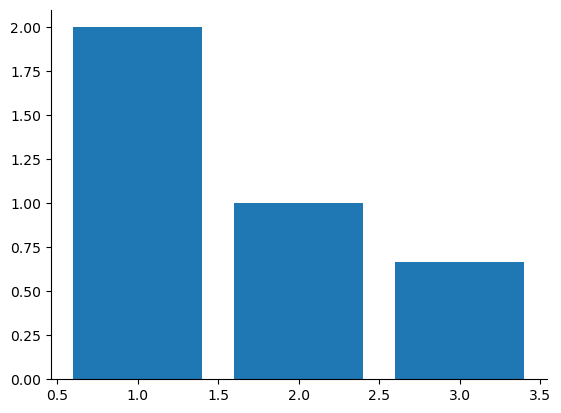

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.bar(list(range(1, n)), sfs)
sns.despine()

if i know the classes / pop locations at each state, I can compute the 

In [6]:
np.array(range(n, 1, -1))

array([6, 5, 4, 3, 2])

In [173]:
import numpy as np
from scipy.special import binom
from itertools import permutations
from collections import defaultdict
import pprint

def partitions(n):
    if n == 0:
        yield []
        return
    for p in partitions(n-1):
        yield [1] + p
        if p and (len(p) < 2 or p[1] > p[0]):
            yield [p[0] + 1] + p[1:]

def multinom(params):
    if len(params) == 1:
        return 1
    return binom(sum(params), params[-1]) * multinom(params[:-1])

# def parents(p, q):
#     idx = np.array(list(range(n)))
#     _p = np.array([p.count(i) for i in range(0, n)])
#     _q = np.array([q.count(i) for i in range(0, n)])
#     # is_parent = int(sum(np.array(_p)*idx != np.array(_q)*idx) == 2 and sum(np.array(_p)*idx - np.array(_q)*idx) == 0)
#     is_parent = int(sum(np.array(_p)*idx - np.array(_q)*idx) == 0)
#     nr_parent_permut = sum(all(np.array(x) == q) for x in set(permutations(q)))
#     print("\t", p, q, _p, _q, is_parent, nr_parent_permut)
#     return is_parent #* nr_parent_permut

# d = defaultdict(list)
# for p in partitions(n):
#     d[len(p)].append(p)


n = 6
rewards = np.zeros((n, n))
for p in partitions(n):
    # print(p)
    # if len(p) == 1:
    #     factor = 1
    # else:
    #     for q in d[len(p)+1]:
    #         factor += parents(p, q)
    # rewards[len(p)-1] += np.array([p.count(i) for i in range(0, n)])
    # rewards[len(p)-1] += np.array([p.count(i) for i in range(0, n)]) * factor
    # rewards[len(p)-1] += np.array([p.count(i) for i in range(0, n)]) * len(set(permutations(p)))
    rewards[len(p)-1] += np.array([p.count(i) for i in range(0, n)]) * multinom(np.array([p.count(i) for i in range(0, n)]))


rewards = np.delete(rewards, 0, axis=0)
rewards = np.delete(rewards, 0, axis=1)
row_sums = rewards.sum(axis=1)
rewards = rewards / row_sums[:, None] * n
rewards

[10. 30. 40. 25.  6.]


array([[1.2, 1.2, 1.2, 1.2, 1.2],
       [2.4, 1.8, 1.2, 0.6, 0. ],
       [3.6, 1.8, 0.6, 0. , 0. ],
       [4.8, 1.2, 0. , 0. , 0. ],
       [6. , 0. , 0. , 0. , 0. ]])

In [66]:
(range(n))

array([0, 1, 2, 3])

In [41]:

multinom([3, 2])

10.0

In [53]:
multinom([4])

1

In [106]:
p = np.array([1, 1, 2])
sum(all(np.array(x) == p) for x in permutations(p))

2

In [94]:
list(map(np.array, permutations(p)))

[array([1, 1, 2]),
 array([1, 2, 1]),
 array([1, 1, 2]),
 array([1, 2, 1]),
 array([2, 1, 1]),
 array([2, 1, 1])]

In [97]:
list(permutations(p))

[(1, 1, 2), (1, 2, 1), (1, 1, 2), (1, 2, 1), (2, 1, 1), (2, 1, 1)]